In [36]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense 
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout , Flatten
from keras.layers.convolutional import Conv2D , MaxPooling2D
import pickle
import json
import os
import sys
import PIL as pl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras_preprocessing import image as kerasImage
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
from imgSearchHelper import image_pyramid, sliding_window
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from imgSearchHelper import sliding_window
from imgSearchHelper import image_pyramid
import numpy as np
import argparse
import imutils
import time
import cv2
from tensorflow.keras.applications import ResNet50

In [37]:
#GLobal Variables 
imageWidth = 64
imageHeight = 64
path ='../img'
testRatio = 0.2
listCategories=[]
nbOfCategories=0
#model settings 
batchSizeVal=50
epochsVal=2 
stepsPerEpochVal=2000

In [38]:
def loadData():
    #select source of the data 
    global listCategories
    global nbOfCategories

    
    listCategories = os.listdir(path)
    nbOfCategories = len(listCategories)
    
    #create two list that the first conatin the images and the second contains their categories 
    images=[]
    imagesCategory=[]
    for category in listCategories:
        imagesInsideFolder = os.listdir(path+'/'+category)
        for img in  imagesInsideFolder:
            curImg = cv2.imread(path+'/'+category+'/'+img)
            curImg = cv2.resize(curImg,(imageWidth,imageHeight))
            images.append(curImg)
            imagesCategory.append(category)
    
    return np.array(images) , np.array(imagesCategory)
images , imagesCategory = loadData()

## 3  PreProcessing
why we must to add depth of one to cnn ?? 

In [39]:
#spliting Data
X_train,X_test,y_train,y_test =train_test_split(images,imagesCategory,test_size=testRatio,random_state=5)

<function matplotlib.pyplot.show(close=None, block=None)>

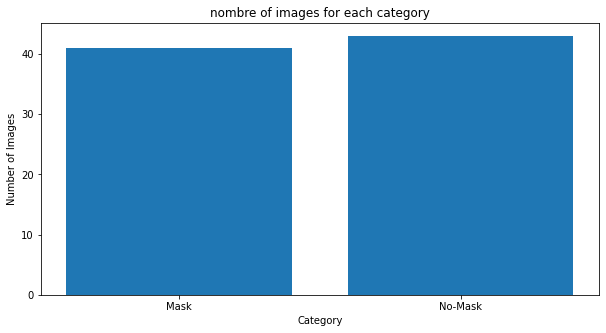

In [40]:
#count nombre of images per categories in the train data
nbOfSimplesPerCategory=[]
for i in listCategories:
    nbOfSimplesPerCategory.append((np.where(y_train == i)[0].size))

#show images distribution in our data train
plt.figure(figsize=(10,5))
plt.bar(listCategories,nbOfSimplesPerCategory )
plt.title("nombre of images for each category")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show

In [41]:
label_encoder = LabelEncoder()
def preProcessing(X_train,X_test,y_train,y_test):
    #we can here use onehot coding or greyscale or any preprocessing 
    X_train = X_train/255
    X_test = X_test /255
    

    #add depth of one to cnn work properly 
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],X_test.shape[3])


    #one hot coding for our categories
    
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.fit_transform(y_test)
#     label_encoder.inverse_transform(y_test)

    
    y_train = to_categorical(y_train,nbOfCategories)
    y_test = to_categorical(y_test,nbOfCategories)
                
    
    
    return X_train,X_test,y_train,y_test

In [42]:
#prepoexessing the data
X_train,X_test,y_train,y_test = preProcessing(X_train,X_test,y_train,y_test)

In [43]:
y_train.shape

(84, 2)

## 4 Model Train
So in the section we will  make experiments to find the better set of parameter for your model.
we will start asking the right question : 
- How can you get better performance from your deep learning model?
- How can I improve accuracy?
- What can I do if my neural network performs poorly?\


so in this section we will  try to answer this questions by :

- Improve Performance With Data.
- Improve Performance With Algorithm Tuning.

we will use as architecture for our model the **LeNet** architucture by Yann LeCun .
<br> - first because it's A great idea to start with  a good architucture which it is  become the standard for this kind of problem .<br> - second because it is one of the simplest architectures. 

In [44]:
#for fitting the model
batchSizeVal=32
epochsVal=30 
stepsPerEpochVal=len(X_train)//batchSizeVal
validation_steps = len(X_test)//batchSizeVal

In [45]:
noOfFilters = 32 
sizeOfFilter1=(5,5)
sizeOfFilter2 =(3,3)
sizeOfPool =(2,2)
noOfNode=64

In [46]:
def plotHistory(history):
    plt.figure(1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training','validation'])
    plt.title('Loss')
    plt.xlabel('epoch')

    plt.figure(2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['training','validation'])
    plt.title('Accuracy')
    plt.xlabel('epoch')

    plt.show()


In [47]:
#this model is based in lenet model
def myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode):

    model =Sequential()
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters, sizeOfFilter1, activation='relu', input_shape=(imageWidth,imageHeight,3)))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters*4, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add Flatten Layer        
    model.add(Flatten())
    
#     #add dropout layer
#     model.add(Dropout(0.5)) 
    
    #add Dense layer
    model.add(Dense(500, activation='relu'))
    model.add(Dense(nbOfCategories, activation='softmax'))
    
    #compile the model
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [48]:
model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)
print(model.summary()) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)             

C:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [49]:
history = model.fit(X_train, y_train, epochs=epochsVal,validation_data=(X_test, y_test), batch_size=batchSizeVal)

Epoch 1/30
3/3 [==============================] - 2s 335ms/step - loss: 0.7488 - accuracy: 0.4881 - val_loss: 0.6822 - val_accuracy: 0.5714
Epoch 2/30
3/3 [==============================] - 1s 160ms/step - loss: 0.6831 - accuracy: 0.5119 - val_loss: 0.6365 - val_accuracy: 0.6667
Epoch 3/30
3/3 [==============================] - 0s 160ms/step - loss: 0.6085 - accuracy: 0.6905 - val_loss: 0.6146 - val_accuracy: 0.6667
Epoch 4/30
3/3 [==============================] - 0s 158ms/step - loss: 0.5450 - accuracy: 0.7500 - val_loss: 0.4016 - val_accuracy: 0.9048
Epoch 5/30
3/3 [==============================] - 0s 168ms/step - loss: 0.4120 - accuracy: 0.8929 - val_loss: 0.3023 - val_accuracy: 0.9048
Epoch 6/30
3/3 [==============================] - 0s 172ms/step - loss: 0.3258 - accuracy: 0.8929 - val_loss: 0.2091 - val_accuracy: 0.9524
Epoch 7/30
3/3 [==============================] - 1s 175ms/step - loss: 0.2307 - accuracy: 0.9048 - val_loss: 0.2598 - val_accuracy: 0.8571
Epoch 8/30
3/3 [====

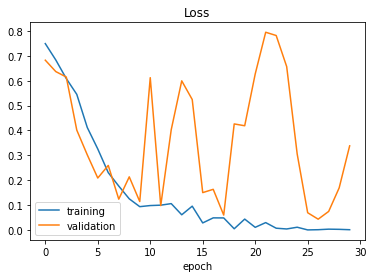

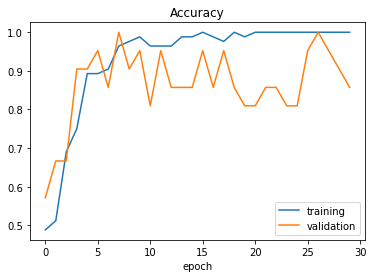

1/1 [==============================] - 0s 58ms/step - loss: 0.3383 - accuracy: 0.8571


0.8571428656578064

In [50]:
plotHistory(history)
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

In [89]:
img_directory = r"D:\M1\NNL\Projet\ImageAnnotator\testImages\22.png"
img_pred = kerasImage.load_img(img_directory, target_size = (64, 64))
img_pred = kerasImage.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis = 0)
prediction = model.predict(img_pred)
print(prediction[0][1])
print(label_encoder.inverse_transform([int(prediction[0][0])]))

1.0
['Mask']


after we run our model for 30 epochs we got a very high accuracy on our training dataset
and we want now to evalute our model in our test dataset
we got only 65% : so this is an exemple of overfitting because in training set it tends to
do so good (99%) but on test set it is having only 65% accuracy
so most likely there is an overfitting happening 


### 1- Improve Performance With Data


so to skip the overfitting we will try to  reuse the old model with two changes : 
- supplying data augmentations to our model as our first layer to produce new sampels 
- adding  a dropout layer to drop randomly  in each pass à 20% of neurons to have better geberalization

**Data augmentations** on images would include transformations like : 
- Flipping the image eithre horizontally or vertically 
- Rotation the image 
- Zooming inour out on the image 
- Cropping the image
- Varying the color on the image


In [15]:
#generate other images from our dataset
dataGenerator =ImageDataGenerator(zoom_range=0.15,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.15,
                                  horizontal_flip=True,
                                  rotation_range=20,
                                  fill_mode="nearest")

In [16]:
noOfFilters = 32 
sizeOfFilter1=(5,5)
sizeOfFilter2 =(3,3)
sizeOfPool =(2,2)
noOfNode=500

model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)
print(model.summary()) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

In [17]:
history = model.fit_generator(dataGenerator.flow(X_train,y_train,
                                                 batch_size=batchSizeVal),
                                                 steps_per_epoch=stepsPerEpochVal,
                                                validation_data=(X_test, y_test),
                                                epochs=epochsVal,
                                                shuffle=1)

C:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
2/2 [==============================] - 2s 516ms/step - loss: 0.9073 - accuracy: 0.4375 - val_loss: 0.8233 - val_accuracy: 0.4286
Epoch 2/30
2/2 [==============================] - 1s 273ms/step - loss: 0.7557 - accuracy: 0.4423 - val_loss: 0.6903 - val_accuracy: 0.4286
Epoch 3/30
2/2 [==============================] - 0s 236ms/step - loss: 0.6830 - accuracy: 0.5000 - val_loss: 0.6812 - val_accuracy: 0.6667
Epoch 4/30
2/2 [==============================] - 0s 296ms/step - loss: 0.6788 - accuracy: 0.7500 - val_loss: 0.6757 - val_accuracy: 0.7143
Epoch 5/30
2/2 [==============================] - 0s 271ms/step - loss: 0.6937 - accuracy: 0.4808 - val_loss: 0.6653 - val_accuracy: 0.6667
Epoch 6/30
2/2 [==============================] - 0s 187ms/step - loss: 0.6621 - accuracy: 0.7885 - val_loss: 0.6662 - val_accuracy: 0.4286
Epoch 7/30
2/2 [==============================] - 0s 194ms/step - loss: 0.6497 - accuracy: 0.5962 - val_loss: 0.6558 - val_accuracy: 0.4286
Epoch 8/30
2/2 [====

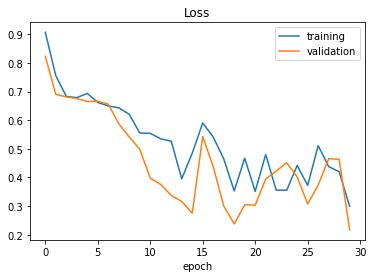

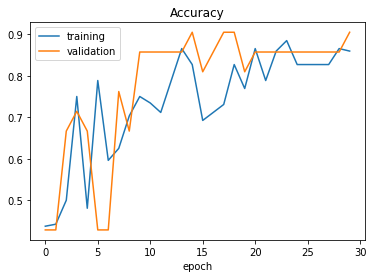

1/1 [==============================] - 0s 110ms/step - loss: 0.2166 - accuracy: 0.9048


0.9047619104385376

In [18]:
plotHistory(history)
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

after we run the model
the new accuracy in the training set was à 90% but 
by looking to our test dataset accurarcy we find that it's improved by 75% so this is a huge 
improvement

**benifs of dataaugmentation** 
To accomplish this goal we “replace” the training data with randomly transformed, augmented data.

In practice, this leads to a model that performs better on our validation/testing data but perhaps performs slightly worse on our training data (to due to the variations in data caused by the random transforms).

We’ll explore how data augmentation can reduce overfitting and increase the ability of our model to generalize via two experiments.

By using data augmentation we were able to combat overfitting!

In nearly all situations, unless you have very good reason not to, you should be performing data augmentation when training your own neural networks.

### Regularizations
dropout also is a great approach to curb overfitting the training data. <br>
so we will test many values for dropout layers and see the diffreence 



In [16]:
#this model is based in lenet model
def myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode):

    model =Sequential()
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters, sizeOfFilter1, activation='relu', input_shape=(imageWidth,imageHeight,3)))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters*4, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add Flatten Layer        
    model.add(Flatten())
    
    #add dropout layer
    model.add(Dropout(0.2)) 
    
    #add Dense layer
    model.add(Dense(500, activation='relu'))
    model.add(Dense(nbOfCategories, activation='softmax'))
    
    #compile the model
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)

In [23]:
history = model.fit_generator(dataGenerator.flow(X_train,y_train,
                                                 batch_size=batchSizeVal),
                                                 steps_per_epoch=stepsPerEpochVal,
                                                validation_data=(X_test, y_test),
                                                epochs=epochsVal,
                                                shuffle=1)

plotHistory(history)
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

Epoch 1/30
2/2 [==============================] - 0s 169ms/step - loss: 0.3795 - accuracy: 0.8269 - val_loss: 0.2608 - val_accuracy: 0.9524
Epoch 2/30
2/2 [==============================] - 0s 145ms/step - loss: 0.4209 - accuracy: 0.8654 - val_loss: 0.2324 - val_accuracy: 0.9048
Epoch 3/30
2/2 [==============================] - 0s 148ms/step - loss: 0.3358 - accuracy: 0.9038 - val_loss: 0.3619 - val_accuracy: 0.8571
Epoch 4/30
2/2 [==============================] - 0s 155ms/step - loss: 0.5552 - accuracy: 0.7885 - val_loss: 0.3146 - val_accuracy: 0.8571
Epoch 5/30
2/2 [==============================] - 0s 213ms/step - loss: 0.4182 - accuracy: 0.7885 - val_loss: 0.2374 - val_accuracy: 0.9048
Epoch 6/30
2/2 [==============================] - 0s 154ms/step - loss: 0.3124 - accuracy: 0.9231 - val_loss: 0.2268 - val_accuracy: 0.9524
Epoch 7/30
2/2 [==============================] - 0s 170ms/step - loss: 0.5461 - accuracy: 0.7812 - val_loss: 0.3441 - val_accuracy: 0.8571
Epoch 8/30
2/2 [====

NameError: name 'plotHistory' is not defined

We can see that for this problem and for the chosen network configuration that using dropout in the hidden layers did not lift performance. In fact, performance was worse than the baseline.

It is possible that additional training epochs are required or that further tuning is required to the learning rate.

## improve performance with algorithm tuning

### Size of Batch  

we will try different size of batch : 
- Try batch size equal to training data size, memory depending (batch learning).
- Try a batch size of one (online learning).
- Try a grid search of different mini-batch sizes (8, 16, 32, …).
- Try training for a few epochs and for a heck of a lot of epochs.

In [22]:
model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)
history = model.fit_generator(dataGenerator.flow(X_train,y_train,
                                                 batch_size=batchSizeVal),
                                                 steps_per_epoch=stepsPerEpochVal,
                                                validation_data=(X_test, y_test),
                                                epochs=epochsVal,
                                                shuffle=1)

plotHistory(history)
test_loss, test_acc = model.evaluate(X_test, y_test)
print ('test_acc : ',test_acc)
print('--------------------------------------------')

C:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
2/2 [==============================] - 1s 478ms/step - loss: 0.9351 - accuracy: 0.5000 - val_loss: 0.6915 - val_accuracy: 0.5238
Epoch 2/30
2/2 [==============================] - 0s 169ms/step - loss: 0.7477 - accuracy: 0.3906 - val_loss: 0.6986 - val_accuracy: 0.5714
Epoch 3/30
2/2 [==============================] - 0s 194ms/step - loss: 0.6976 - accuracy: 0.5000 - val_loss: 0.6873 - val_accuracy: 0.5714
Epoch 4/30
2/2 [==============================] - 0s 150ms/step - loss: 0.6855 - accuracy: 0.6538 - val_loss: 0.6907 - val_accuracy: 0.4762
Epoch 5/30
2/2 [==============================] - 0s 206ms/step - loss: 0.6745 - accuracy: 0.5769 - val_loss: 0.7098 - val_accuracy: 0.4286
Epoch 6/30
2/2 [==============================] - 0s 151ms/step - loss: 0.6970 - accuracy: 0.4423 - val_loss: 0.6741 - val_accuracy: 0.5714
Epoch 7/30
2/2 [==============================] - 0s 134ms/step - loss: 0.6654 - accuracy: 0.7308 - val_loss: 0.6702 - val_accuracy: 0.5714
Epoch 8/30
2/2 [====

NameError: name 'plotHistory' is not defined

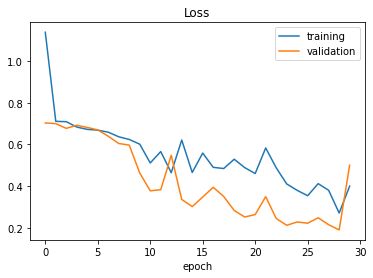

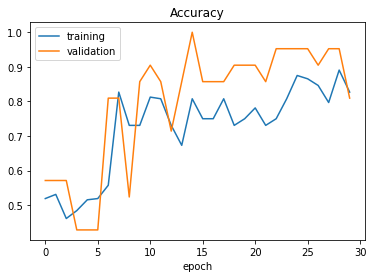

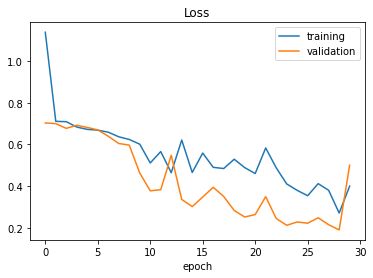

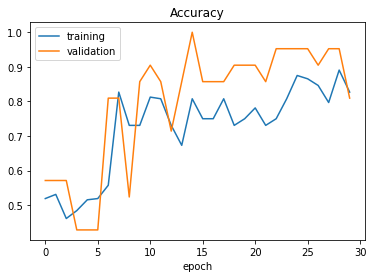

In [26]:
for i in range(2):
    plotHistory(history)

### Numbreof Epochs 

Try training for a few epochs and for a heck of a lot of epochs.

In [20]:
model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)
history = model.fit_generator(dataGenerator.flow(X_train,y_train,
                                                 batch_size=batchSizeVal),
                                                 steps_per_epoch=stepsPerEpochVal,
                                                validation_data=(X_test, y_test),
                                                epochs=epochsVal,
                                                shuffle=1)

plotHistory(history)
test_loss, test_acc = model.evaluate(X_test, y_test)
print ('test_acc : ',test_acc)
print('--------------------------------------------')

Epoch 1/30
2/2 [==============================] - 1s 350ms/step - loss: 1.4669 - accuracy: 0.4688 - val_loss: 0.8157 - val_accuracy: 0.4286
Epoch 2/30
2/2 [==============================] - 0s 157ms/step - loss: 0.6707 - accuracy: 0.5781 - val_loss: 0.7272 - val_accuracy: 0.5714
Epoch 3/30
2/2 [==============================] - 0s 166ms/step - loss: 0.7123 - accuracy: 0.5469 - val_loss: 0.7005 - val_accuracy: 0.5714
Epoch 4/30
2/2 [==============================] - 0s 187ms/step - loss: 0.6814 - accuracy: 0.5962 - val_loss: 0.6946 - val_accuracy: 0.5714
Epoch 5/30
2/2 [==============================] - 0s 179ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5714
Epoch 6/30
2/2 [==============================] - 0s 164ms/step - loss: 0.6892 - accuracy: 0.5781 - val_loss: 0.6961 - val_accuracy: 0.4286
Epoch 7/30
2/2 [==============================] - 0s 100ms/step - loss: 0.6803 - accuracy: 0.5577 - val_loss: 0.7101 - val_accuracy: 0.4286
Epoch 8/30
2/2 [====

NameError: name 'plotHistory' is not defined

### Numbre of neurons 

# Prediction and test function


# save the model

In [19]:
pickle_out  = open("myModel.pckl","wb")
pickle.dump(model,pickle_out)
pickle_out.close()

TypeError: cannot pickle 'weakref' object

In [20]:
model.save("my_model")
model.save_weights("weights.h5")

INFO:tensorflow:Assets written to: my_model\assets


In [35]:
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 8
ROI_SIZE = (120, 120)
INPUT_SIZE = (imageWidth, imageHeight)

# load our network weights from disk
print("[INFO] loading network...")

#img_directory = 'D:/M1/NNL/Projet/ImageAnnotator/inputImages/imagemask ('+str(
#    i)+')' + '.png'
img_direc = 'D:/M1/NNL/Projet/ImageAnnotator/inputImages/imagemask (333).png'
#img_pred = image.load_img(path = img_direc, target_size=(100, 100))
#img_pred = image.img_to_array(img_pred)
#img_pred = np.expand_dims(img_pred, axis=0)

# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(img_direc)
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x)
        y = int(y)
        w = int(ROI_SIZE[0])
        h = int(ROI_SIZE[1])
        # take the ROI and preprocess it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))

end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
    end - start))
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")

# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
#preds2 = model2.predict(rois)
prediction = model.predict(rois)
print(" PREDICTION " , prediction)

end = time.time()
#print("[INFO] classifying ROIs took {:.5f} seconds".format(    end - start))
# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
#preds = imagenet_utils.decode_predictions(preds2, top=1)
labels = {}

for i in range(0, len(prediction)):
    # grab the prediction information for the current ROI
    prob = 0.92

    if(int(prediction[i][0]) == 0):
        label = "mask"
    else:
        label = "no-mask"
        
    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if  label == "mask":
        print(" PROBABILITY " ,prob)
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]
        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

for label in labels.keys():
    # clone the original image so that we can draw on it
    #print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()
    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),
                        (0, 255, 0), 2)
    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    cv2.imshow("Before", clone)
    clone = orig.copy()

# extract the bounding boxes and associated prediction
# probabilities, then apply non-maxima suppression
boxes = np.array([p[0] for p in labels[label]])
proba = np.array([p[1] for p in labels[label]])
boxes = non_max_suppression(boxes, proba)
# loop over all bounding boxes that were kept after applying
# non-maxima suppression
for (startX, startY, endX, endY) in boxes:
    # draw the bounding box and label on the image
    cv2.rectangle(clone, (startX, startY), (endX, endY),
                    (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(clone, label, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output after apply non-maxima suppression
cv2.imshow("After", clone)
cv2.waitKey(0)



[INFO] loading network...
[INFO] looping over pyramid/windows took 0.98782 seconds
[INFO] classifying ROIs...
 PREDICTION  [[1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.

-1

# real time detector


In [ ]:
import cv2
import numpy as np
imageWidth = 64
imageHeight = 64

#load model
from tensorflow import keras
model = keras.models.load_model('my_model')
model.load_weights("weights.h5")


#run camera
cap = cv2.VideoCapture(1)
cap.set(3,1000)
cap.set(4, 600)

while True:
    sucess, imgOriginal = cap.read()
    img = np.asarray(imgOriginal)
    img = cv2.resize(img, (imageWidth, imageHeight))
    img = img / 255
    img=img.reshape(1,imageWidth,imageWidth,3)
    
    probVal = np.amax(model.predict(img))
    if model.predict_classes(img)[0] == 0 :
        category = 'ya3tik essa7a'
        colortext =(0,245,128)
    else :
        category = 'albess mask mte3k yehdik'
        colortext =(0,0,220)
        
    cv2.putText(imgOriginal,category +" "+str(probVal),(0,50),cv2.FONT_HERSHEY_COMPLEX,1,colortext,2)

    cv2.imshow("processed image", imgOriginal)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

In [ ]:
import cv2
import face_recognition
import numpy as np
imageWidth = 64
imageHeight = 64

#load model
from tensorflow import keras
model = keras.models.load_model('my_model')
model.load_weights("weights.h5")


#run camera
cap = cv2.VideoCapture(1)
cap.set(3,1000)
cap.set(4, 600)

while True:
    sucess, imgOriginal = cap.read()
    img = np.asarray(imgOriginal)
    img = cv2.resize(img, (imageWidth, imageHeight))
    img = img / 255
    img=img.reshape(1,imageWidth,imageWidth,3)
    
    
    faceLoc = face_recognition.faceLoc(imgOriginal)[0]
    cv2.rectangle(imgOriginal,(faceLoc[3],faceLoc[0]),(faceLoc[1],faceLoc[2]),(255,0,255),2)
    
    
    
    probVal = np.amax(model.predict(img))
    if model.predict_classes(img)[0] == 0 :
        category = 'With_Mask'
        colortext =(0,245,128)
    else :
        category = 'Without_Mask'
        colortext =(0,0,220)
        
    cv2.putText(imgOriginal,category +" "+str(probVal),(0,50),cv2.FONT_HERSHEY_COMPLEX,1,colortext,2)

    cv2.imshow("processed image", imgOriginal)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

ModuleNotFoundError: No module named 'face_recognition'